In [ ]:
import numpy as np
import scipy

from scipy.special import legendre
import scipy.integrate as integrate

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

## A glimpse at $H_n$

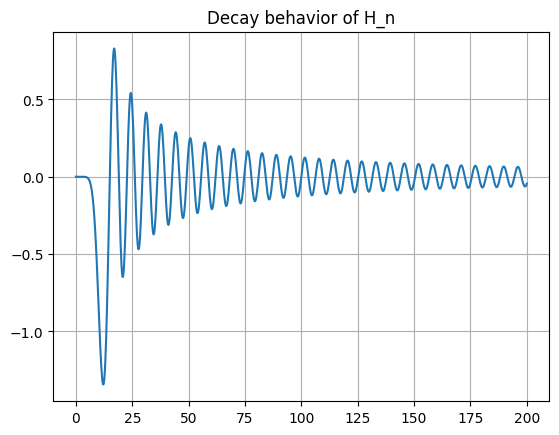

In [ ]:
def Hn(x,N):
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u) * p(u),0,1)[0]


xx = np.linspace(0,200,1000)
yy = np.array([Hn(x,10) for x in xx])
plt.plot(xx,yy)
plt.title("Decay behavior of H_n")
plt.grid();

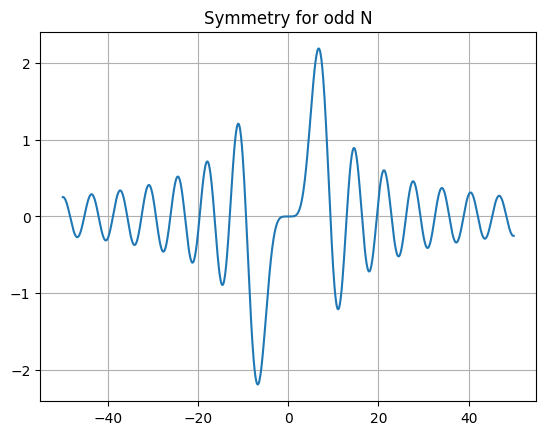

In [ ]:
xx = np.linspace(-50,50,1000)
yy = np.array([Hn(x,5) for x in xx])
plt.plot(xx,yy)
plt.title("Symmetry for odd N")
plt.grid();

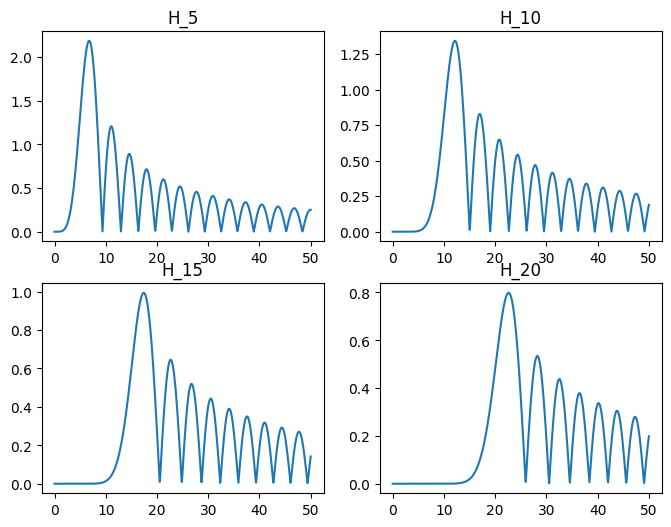

In [ ]:
xx = np.linspace(0,50,1000)
fig,ax = plt.subplots(2,2,figsize=(8,6))
for i,n in enumerate([5,10,15,20]):
    yy = np.array([Hn(x,n) for x in xx])
    ax[i//2,i%2].plot(xx,np.abs(yy))
    ax[i//2,i%2].set_title(f"H_{n}")

Nothing surprising; it shows high oscilations due to the sin/cos term and it seems the higher the order of the Legendre polynomial then it "delays" the bump.
The symmetry of the function is also apparent for even/odd degree.

## Numerical solution of eigenfunction equation


We want to solve the following equation:

$$ \lambda_{N,m,n} R_{N,m,n}(r) = \int_{0}^{a} \Psi_N(r,r') R_{N,m,n}(r') \text{dr'} $$

For:

$$ \Psi_{N}(r,r') = \int_{0}^{c} H_{N}(-r'\rho) H_{N}(r\rho) G(\rho) (r' \rho)^{2} d\rho$$

The idea is to discretize the above eigenfunction equation into:

$$ \lambda_{N,m,n} R_{N,m,n}(r) \sim \sum_{i=0}^{K} w_i \Psi_N(r,r_i) R_{N,m,n}(r_i) $$

The idea is to choose $r$ as the same points of the quadrature points so we get equations of the form:

$$ \lambda_{N,m,n} R_{N,m,n}(r_j) \sim \sum_{i=0}^{K} w_i \Psi_N(r_j,r_i) R_{N,m,n}(r_i) $$

Note that if we write this equation for every $0 \leq j \leq K$ we get a linear equation of the form:

$$ \lambda_{N,m,n}R = \Phi_{N} R$$

Where $R = (R_{N,m,n}(r_1), \cdots,R_{N,m,n}(r_K) ))$ and $\Phi_{i,j} = w_i \Psi(r_j, r_i)$

And then we can solve this with known numerical algorithms.

However as we see above $H_n$ has high oscilations so evenly spaced point will fail to capture its behavior hence we resort to the Gauss–Legendre method.

#### TODO:

- Update Hn and Psi functiosn to be vectorized easily to overcome the quadratic evaluation in K
- Check for better quadrature methods for this highly oscilating functions



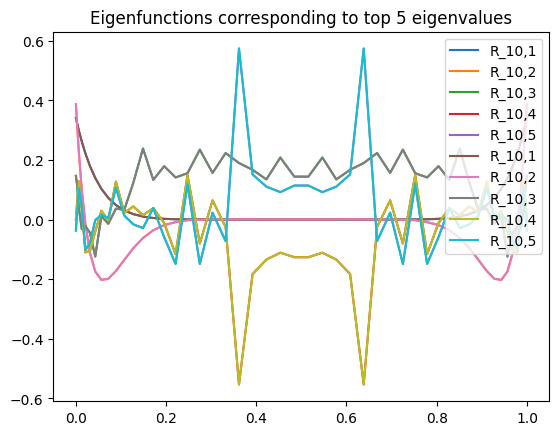

In [ ]:
""" Small script to deomonstrate the computation, very slow due to non-vectorized integration"""

def Hn(x,N):
    # Quad is an adaptive method hence cannot be vectorized
    # TODO: Change it to np.trapz by using samples of the integrand to be able to vectorize it.
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u) * p(u),0,1)[0]


# A sample function to act like radial power spectrum
G = lambda x: np.exp(-x**2)

def Psi(x,y,N):
    return integrate.quad(lambda p: Hn(-x*p,N)* Hn(y*p,N)*G(p)*(y*p)**2,0,1)[0]

N = 10
K = 50 # Number of Legenndre roots/ accuracy of integration
X, w = scipy.special.roots_legendre(K) # Golub-Welsch algorithm
U = np.array([[w[i]*Psi(y,x,N) for i,x in enumerate(X)] for y in X]) # The phi in our formula

eigenvalues, eigenvectors = scipy.linalg.eig(U)
eigenvalues = np.absolute(eigenvalues)
indices = np.argsort(eigenvalues)[::-1]

points = [0.5*(x+1) for x in X]

for i in range(5):
    plt.plot(points,eigenvectors[:,indices[i]].real, label=f"R_{N},{i+1}")

plt.title("Eigenfunctions corresponding to top 5 eigenvalues")
plt.legend(loc='upper right');
plt.grid();

for i in range(5):
    plt.plot(points,eigenvectors[:,indices[i]].real, label=f"R_{N},{i+1}")

plt.title("Eigenfunctions corresponding to top 5 eigenvalues")
plt.legend(loc='upper right');
plt.grid();

The above script is a sampel script to implement the solution however it's very slow as it's dependent on Scipy's quad function which can't be vectorized, for speed purposes I rewrite the above in jax to utilize it's vmap function that can do the $O(K^2)$ evaluations of $\Psi$ efficiently.

### Gauss quadrature

2024-12-25 17:24:10.316362: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


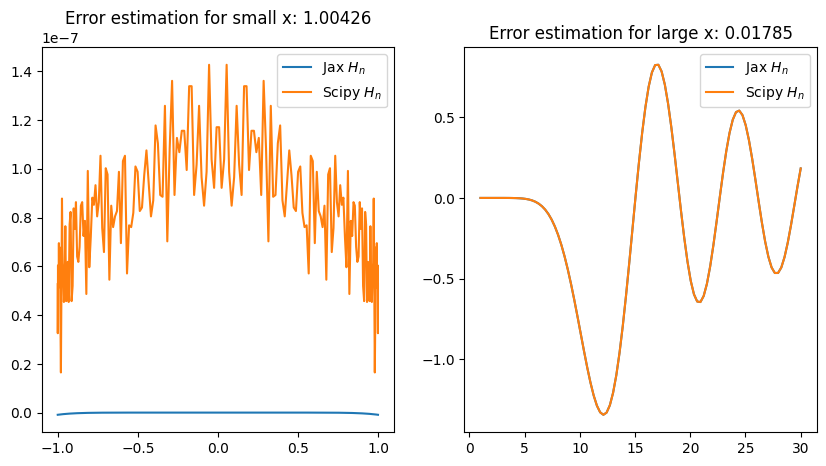

In [ ]:
N = 10
K = 200 # Number of Legendre roots
X0, w = scipy.special.roots_legendre(K) # Golub-Welsch algorithm
pN = legendre(N)
X = 0.5*X0 + 0.5

X,w = jnp.array(X), jnp.array(w)
pX = jnp.array(pN(X))

G = lambda x: jnp.exp(-x**2)
g = (lambda x: jnp.cos(x)) if N % 2 == 0 else (lambda x: jnp.sin(x))

def Hn_vect(x):
    """
    Vectorized H_n with Gauss quadrature using pre-computed Legendre roots
    Note that we transform the Legendre points to interval [0,1] + multiply by 0.5 due to interval transformation.
    """
    y = g(x[:,None]*X) * pX
    return  2 * jnp.pi * jnp.sum(w*y,axis=-1)

def compare_results(x,y):
  return (x - y) / jnp.maximum(x,y)

fig, ax = plt.subplots(1,2,figsize=(10,5))


scipy_yy = Hn_vect(X0)
jax_yy = jnp.array([Hn(x,N) for x in X0])
error1 = jnp.mean(compare_results(scipy_yy,jax_yy))

xx1 = jnp.linspace(1,30,100)
scipy_yy1 = Hn_vect(xx1)
jax_yy1 = jnp.array([Hn(x,N) for x in xx1])
error2 = jnp.mean(compare_results(scipy_yy1,jax_yy1))

ax[0].plot(X0,jax_yy,label='Jax $H_n$')
ax[0].plot(X0,scipy_yy,label='Scipy $H_n$')
ax[0].set_title(f"Error estimation for small x: {error1:.5f}")
ax[0].legend();

ax[1].plot(xx1,jax_yy1,label='Jax $H_n$')
ax[1].plot(xx1,scipy_yy1,label='Scipy $H_n$')
ax[1].set_title(f"Error estimation for large x: {error2:.5f}")
ax[1].legend();

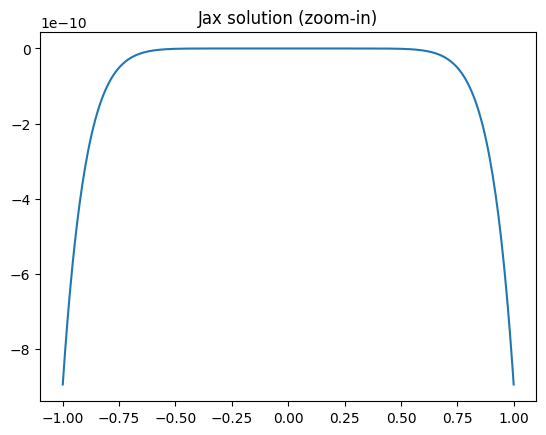

In [ ]:
plt.title("Jax solution (zoom-in)")
plt.plot(X0,jax_yy);

We see the Guass-Quadrature suffers from numerical instability especially for small values of x.

### Clenshaw-Curtis quadrature

In [ ]:
D = np.array([[np.cos(n*k*np.pi / (K/2)) for n in range(N//2)] for k in range(N//2)])
D[:,0] = D[:,0] * (K/2)
D[0,:]= D[0,:] * (K/2)

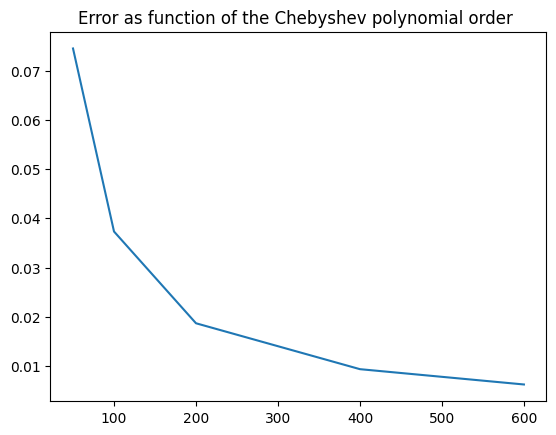

In [ ]:
class ClenshawCurtisQuadrature:
    def __init__(self, K):
        self.chebyshev_roots = np.array([np.cos(k*np.pi/K) for k in range(K//2)])

        d = np.array([2/(1-(2*k)**2) for k in range(1,K//2-1)])
        d = np.append([1],d)
        d = np.append(d,[1/(1-(K**2))])

        D = 2/K *np.array([[np.cos(n*k*np.pi / (K//2)) for n in range(K//2)] for k in range(K//2)])
        D[:,0] = D[:,0] * 0.5
        D[:,K//2-1]= D[:,K//2-1] * 0.5

        self.w = D.T @ d

    def integrate(self, f):
        y = f(self.chebyshev_roots) + f(-self.chebyshev_roots)
        return np.dot(self.w,y)

Ks = [50,100,200,400,600]

# Test function for high frequencies
f = lambda x: np.cos(x)
true_val = scipy.integrate.quad(f, -1,1)[0]
errors = []
for k in Ks:
    cc_quad = ClenshawCurtisQuadrature(k)
    I = cc_quad.integrate(f)
    errors.append(np.abs((I-true_val))/true_val)

plt.title("Error as function of the Chebyshev polynomial order ");
plt.plot(Ks,errors);

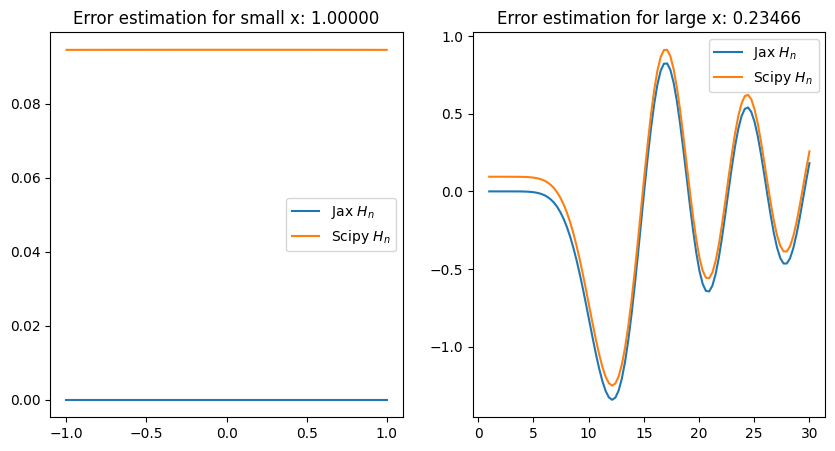

In [ ]:
K = 100 #integration order
chebyshev_roots = jnp.array([jnp.cos(k*jnp.pi/K) for k in range(K//2)])
d = np.array([2/(1-(2*k)**2) for k in range(1,K//2-1)])
d = np.append([1],d)
d = np.append(d,[1/(1-(K**2))])
d = jnp.array(d)

D = 2/K *np.array([[np.cos(n*k*np.pi / (K//2)) for n in range(K//2)] for k in range(K//2)])
D[:,0] = D[:,0] * 0.5
D[:,K//2-1]= D[:,K//2-1] * 0.5
D = jnp.array(D)

w = D.T @ d

def quad_cc(f):
    # Vectorized Clenshaw-Curtis quadrature
    y = f(chebyshev_roots) + f(-chebyshev_roots)
    return jnp.dot(w,y)


@jax.vmap
def Hn_cc(x):
    return 2*jnp.pi*quad_cc(lambda u: g(x*u)*pN(u))

scipy_yy = Hn_cc(X0)
jax_yy = jnp.array([Hn(x,N) for x in X0])
error1 = jnp.mean(compare_results(scipy_yy,jax_yy))

xx1 = jnp.linspace(1,30,100)
scipy_yy1 = Hn_cc(xx1)
jax_yy1 = jnp.array([Hn(x,N) for x in xx1])
error2 = jnp.mean(compare_results(scipy_yy1,jax_yy1))


fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(X0,jax_yy,label='Jax $H_n$')
ax[0].plot(X0,scipy_yy,label='Scipy $H_n$')
ax[0].set_title(f"Error estimation for small x: {error1:.5f}")
ax[0].legend();

ax[1].plot(xx1,jax_yy1,label='Jax $H_n$')
ax[1].plot(xx1,scipy_yy1,label='Scipy $H_n$')
ax[1].set_title(f"Error estimation for large x: {error2:.5f}")
ax[1].legend();

## Interpolating $H_n$

To reduce the overhead we approximate $H_n$ by a Chebyshev polynomial (we cannot one-shot compute it values as the $H_n$ term in the integrand is dependent on x).

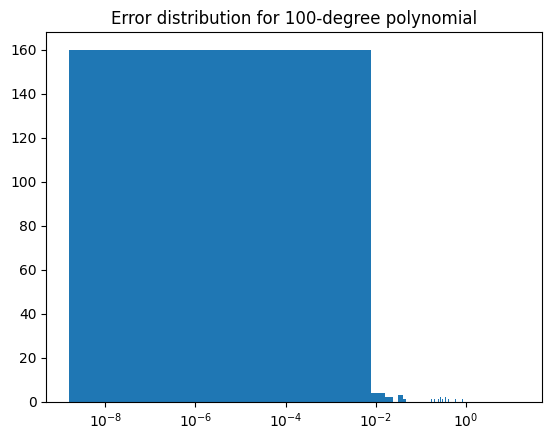

In [ ]:
from scipy.special import eval_chebyt
from scipy.fftpack import dct

def Hn(x,N):
    # Quad is an adaptive method hence cannot be vectorized
    # TODO: Change it to np.trapz by using samples of the integrand to be able to vectorize it.
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u) * p(u),0,1)[0]

N = 10 # Order of equation
K = 200 # Number of Legendre roots
D = 100 # Order for approximating Chebyshev's coefficientss

X0, w = scipy.special.roots_legendre(K) # Golub-Welsch algorithm
scipy_values = np.array([Hn(x,N) for x in X0])

def interpolate_Hn(d):
    # Chebyshev polynomial
    chebyshev_roots = [np.cos(np.pi * (k+ 0.5)/d) for k in range(d)]
    Hn_values = [Hn(x,N) for x in chebyshev_roots]
    chebyshev_coeffs = dct(Hn_values,type=2)/d
    chebyshev_coeffs[0] /= 2

    polynomial = lambda x: np.sum([a_n*eval_chebyt(n,x) for n,a_n in enumerate(chebyshev_coeffs)])
    return polynomial

def plot_interpolation_error_distribution(d):
  chebyshev_p = interpolate_Hn(d)
  chebyshev = np.array([chebyshev_p(x) for x in X0])

  errors = [abs((x-y)/x) for x,y in zip(scipy_values,chebyshev)]
  plt.hist(errors,bins=2000)
  plt.title(f"Error distribution for {d}-degree polynomial")
  plt.xscale('log')


plot_interpolation_error_distribution(100)

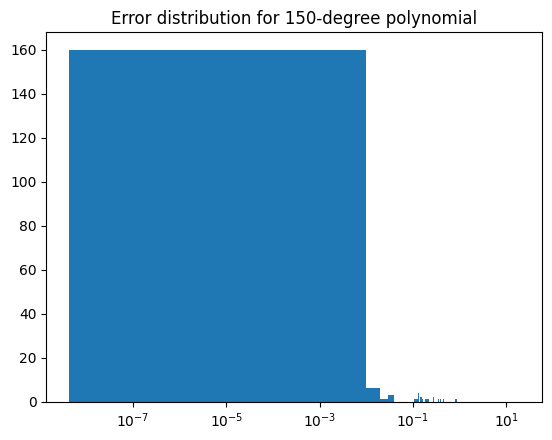

In [ ]:
plot_interpolation_error_distribution(150)

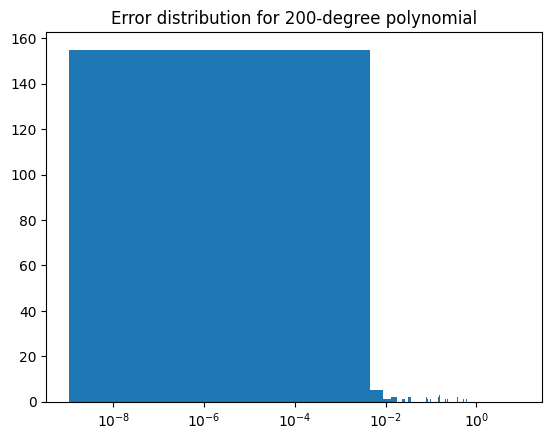

In [ ]:
plot_interpolation_error_distribution(200)

In [ ]:
# A sample function to act like radial power spectrum
G = lambda x: np.exp(-x**2)

def Psi(x,y):
    return integrate.quad(lambda p: chebyshev_p(-x*p)* chebyshev_p(y*p)*G(p)*(y*p)**2,0,1)[0]

chebyshev_p = interpolate_Hn(50)
K = 50 # Number of Legenndre roots/ accuracy of integration
X, w = scipy.special.roots_legendre(K) #Golub-Welsch algorithm
X_s = 0.5*X + 0.5
U = np.array([[w[j]*Psi(x,y) for j,y in enumerate(X_s)] for x in X_s])

In [ ]:
def Psi_old(x,y,N):
    # Assumes c = 1
    return integrate.quad(lambda p: Hn(-y*p,N)* Hn(x*p,N)*G(p)*(y*p)**2,0,1)[0]

U_old = np.array([[w[j]*Psi_old(x,y,N) for j,y in enumerate(X_s)] for x in X_s])

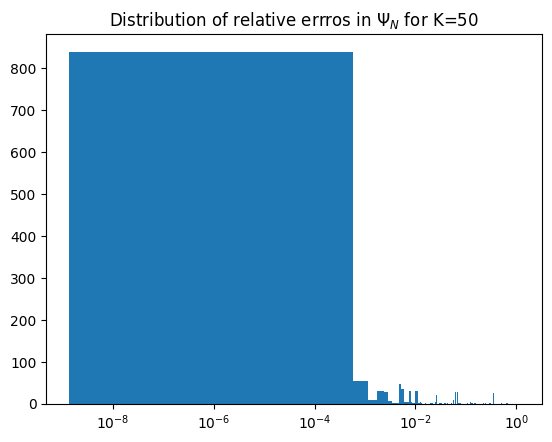

In [ ]:
errors = np.array([abs((x-y)/x) for x,y in zip(U_old.flatten(),U.flatten())])
plt.hist(errors,bins=2000);
plt.title(f"Distribution of relative errros in $\Psi_N$ for K={K}")
plt.xscale('log');

## Pre-computing $H_n$

As means to extra give boost-up we one-shot the values of H_n at multiples of $x_i*x_j$ for $x_i$ being Legendre roots.

The equation we discretize is:

$$ \Psi_{N}(r,r') = \int_{0}^{c} H_{N}(-r'\rho) H_{N}(r\rho) G(\rho) (r' \rho)^{2} d\rho \sim 0.5 \sum_{i=1}^K  w_i H_{N}(-r' x'_i)) H_{N}(r x'_i) G(x'_i) (r'x'_i )^{2} $$

Note that change of variable: $ x'_i = \frac{c}{2}x_i + \frac{c}{2} $

$$ \lambda_{N,m,n} R_{N,m,n}(x'_i) \sim \sum_{j=0}^{K} w_j \Psi_N(x'_i,x'_j) R_{N,m,n}(x'_j) $$

$$ \Psi_N(x'_i,x'_j) \sim \frac{c}{2} \sum_{\ell = 0}^K w_\ell H_{N}(-x'_j x'_{\ell}) H_{N}(x'_i x'_{\ell}) G(x'_{\ell}) (x'_j x'_{\ell})^{2}$$

Meaning the input to $\Psi$ is also a Legendre's root hence we pre-compute values of $H_n$ at $K^2$ multiples of different Legendre roots and then note that for a given $r,r'$ which are essentially $x_i,x_j$ the term $H_N(r \rho) = H_N(r x_i) $ is essentially $H_n$ evaluated at all Legendre roots multiplied by same $x_i$ hence it's just the $i$ row in the matrix saving all the pre-computed results.


Note the negative sign doesn't matter thanks to the property $H_N(-x) = (-1)^N H_N(x)$.

In [ ]:
G = lambda x: np.exp(-x**2)

def Hn(x,N):
    p = legendre(N)
    if N % 2 == 0:
        return 4 * np.pi * integrate.quad(lambda u: np.cos(x*u) * p(u), 0,1)[0]
    return 4 * np.pi * integrate.quad(lambda u: np.sin(x*u) * p(u),0,1)[0]

def approximate_psi_matrix(K):
  X,w = scipy.special.roots_legendre(K)
  X_scaled = 0.5*X + 0.5 # Assumes a = c = 1
  vv = np.array([[Hn(X_scaled[i]*X_scaled[j],N) for j in range(K)] for i in range(K)])
  Gx = G(X_scaled)

  def psi(i,j):
    return 0.5 * np.sum(w * vv[j,:] * vv[i,:] * Gx * (X_scaled[j]*X_scaled)**2)

  U = np.array([[w[j]*psi(i,j) for j in range(K)] for i in range(K)])
  return U

def Psi_old(x,y,N):
    # Assumes c = 1
    return integrate.quad(lambda p: Hn(-y*p,N)* Hn(x*p,N)*G(p)*(y*p)**2,0,1)[0]

In [ ]:
N = 10
K = 100
U = approximate_psi_matrix(K)

In [ ]:
R = 50 # only a subset for evaluation
X,w = scipy.special.roots_legendre(K)
X_s = 0.5*X + 0.5

U_old = np.array([[w[j]*Psi_old(X_s[i],X_s[j],N) for j in range(R)] for i in range(R)])

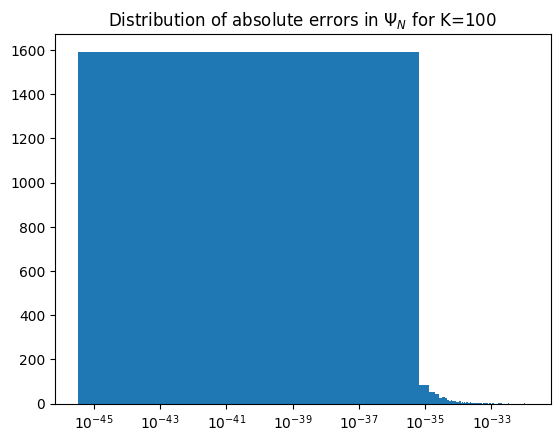

In [ ]:
U_slice = U[:R,:R]
errors = np.array([abs((x-y)) for x,y in zip(U_old.flatten(),U_slice.flatten())])
plt.hist(errors,bins=2000);
plt.title(f"Distribution of absolute errors in $\Psi_N$ for K={K}")
plt.xscale('log');

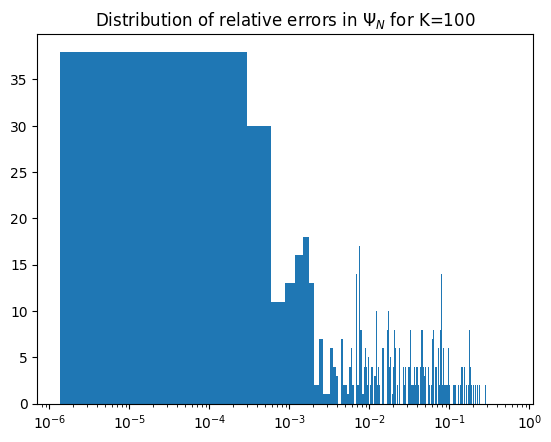

In [ ]:
U_slice = U[:R,:R]
errors = np.array([abs((x-y)/x) for x,y in zip(U_old.flatten(),U_slice.flatten())])
plt.hist(errors,bins=2000);
plt.title(f"Distribution of relative errors in $\Psi_N$ for K={K}")
plt.xscale('log');

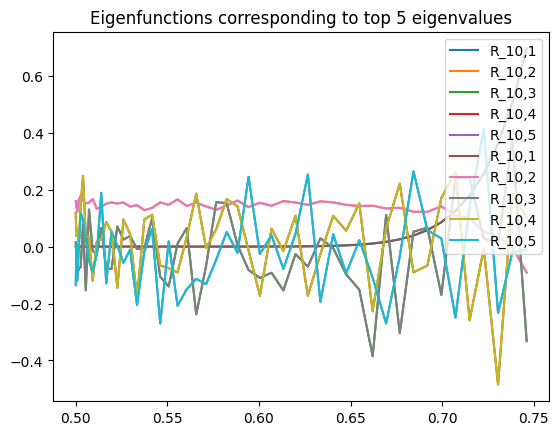

In [ ]:
def decompose_radial_solutions(U):
    eigenvalues, eigenvectors = scipy.linalg.eig(U)
    eigenvalues = np.absolute(eigenvalues)
    indices = np.argsort(eigenvalues)[::-1]

    points = [0.5*(X_s[i]+1) for i in range(U.shape[0])]

    for i in range(5):
        plt.plot(points,eigenvectors[:,indices[i]].real, label=f"R_{N},{i+1}")

    plt.title("Eigenfunctions corresponding to top 5 eigenvalues")
    plt.legend(loc='upper right');
    plt.grid();

    for i in range(5):
        plt.plot(points,eigenvectors[:,indices[i]].real, label=f"R_{N},{i+1}")

    plt.title("Eigenfunctions corresponding to top 5 eigenvalues")
    plt.legend(loc='upper right')
    plt.grid()

decompose_radial_solutions(U_slice)